In [1]:
# adding src to the system path
import sys  
sys.path.insert(0, '/Users/szczekulskij/side_projects/tomography-reconstruction-CNN')

import numpy as np
import pandas as pd
from random import randint
import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
from imutils import rotate
import matplotlib.pyplot as plt
from skimage.transform import radon



# from dataset_generator import generate_polygon, calculate_angles
from src.mock_dataset_generator import create_dataset #, generate_polygon, generate_polygon_subroutine
from src.utils import mse_error, reconstruct, get_split, choose_top_angles, get_non_binary_angles, transform_angles_data

average mse error for 50 polygon-shaped pics: 0.0


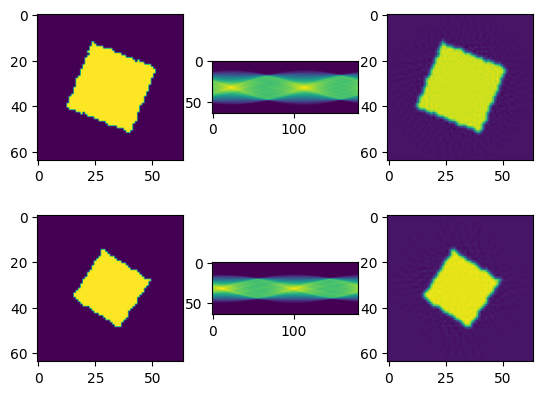

In [5]:
# images_list, sinograms_list, angles_list = create_dataset(30000, single_side_size = 4, img_size = 91)
images_list, sinograms_list, angles_list = create_dataset(12000, single_side_size = 4, img_size = 64)
reconstruct_list = reconstruct(sinograms_list)
print("average mse error for 50 polygon-shaped pics:", mse_error(images_list, reconstruct_list))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images_list[0]) 
axarr[0,1].imshow(sinograms_list[0])
axarr[0,2].imshow(reconstruct_list[0])
axarr[1,0].imshow(images_list[1])
axarr[1,1].imshow(sinograms_list[1])
axarr[1,2].imshow(reconstruct_list[1])

# Sandbox area:

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


def create_model(img_size = 64):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        # layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        # layers.MaxPooling2D((2, 2)), # Might increase performance because it decreases parameters (which is why CNN was created for in the first place)
        # Sams model has 85% of params in dense layer
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(500, activation="relu", kernel_initializer='random_normal',),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(180, activation="sigmoid", kernel_initializer='random_normal',),
    ])

    return model

In [ ]:
model = create_model(64)
model.build((None, 64, 180, 1))

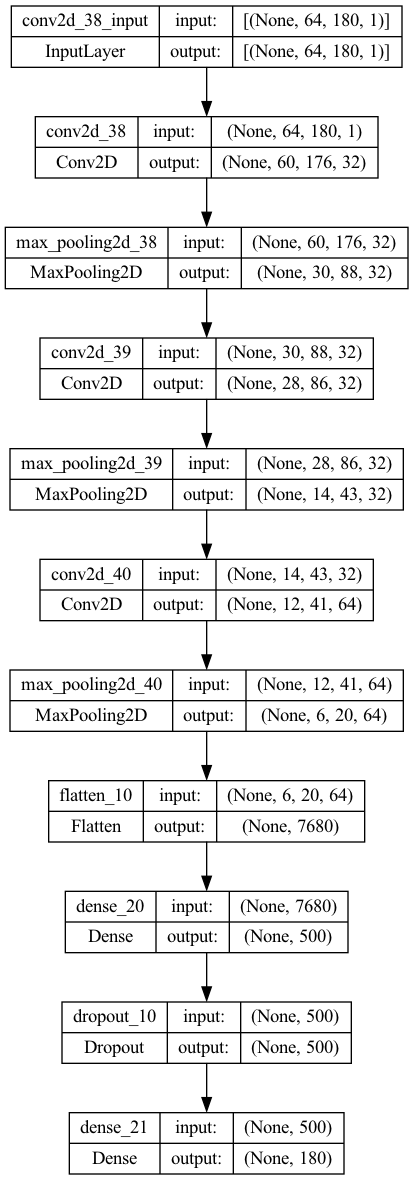

In [ ]:
# model = create_model(64)
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

# callbacks = [
#              EarlyStopping(patience=2),
#              model_checkpoint_callback,
# ]

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 60, 176, 32)       832       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 30, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 86, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 14, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 41, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 20, 64)      

In [ ]:
transformed = transform_angles_data(angles_list)
X_train, X_test, y_train, y_test = get_split(sinograms_list, transformed)


NameError: name 'angles_list' is not defined

In [ ]:
history = model.fit(X_train,y_train, batch_size=300, epochs=200,validation_data=(X_test,y_test))
# history = model.fit(X_train,y_train, batch_size=2000, epochs=600,validation_data=(X_test,y_test))

Epoch 1/200
28/28 [==============================] - 52s 2s/step - loss: 0.4190 - accuracy: 0.0485 - val_loss: 0.4173 - val_accuracy: 0.0608
Epoch 2/200
28/28 [==============================] - 49s 2s/step - loss: 0.4186 - accuracy: 0.0526 - val_loss: 0.4171 - val_accuracy: 0.0572
Epoch 3/200
28/28 [==============================] - 50s 2s/step - loss: 0.4183 - accuracy: 0.0486 - val_loss: 0.4170 - val_accuracy: 0.0569
Epoch 4/200
28/28 [==============================] - 50s 2s/step - loss: 0.4182 - accuracy: 0.0477 - val_loss: 0.4167 - val_accuracy: 0.0522
Epoch 5/200
28/28 [==============================] - 50s 2s/step - loss: 0.4180 - accuracy: 0.0524 - val_loss: 0.4168 - val_accuracy: 0.0464
Epoch 6/200
28/28 [==============================] - 51s 2s/step - loss: 0.4179 - accuracy: 0.0508 - val_loss: 0.4164 - val_accuracy: 0.0625
Epoch 7/200
28/28 [==============================] - 51s 2s/step - loss: 0.4177 - accuracy: 0.0533 - val_loss: 0.4161 - val_accuracy: 0.0550
Epoch 8/200
2

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(X_test)

113/113 [==============================] - 4s 39ms/step


In [ ]:
[0,0.1,0.5,....,1,]

In [ ]:
i = 10
for (truth, prediction) in zip(y_test, predictions):
    real_angles = choose_top_angles(truth)
    predicted_angles = choose_top_angles(prediction)
    print("truth:", real_angles)
    print("prediction:", predicted_angles)
    print()
    i+=1
    if i == 10 :
        break

truth: [12, 98]
prediction: [12, 98]

truth: [60, 150]
prediction: [59, 149]

truth: [49, 139]
prediction: [50, 140]

truth: [45, 135]
prediction: [46, 136]

truth: [37, 127]
prediction: [37, 127]

truth: [43, 133]
prediction: [43, 133]

truth: [33, 123]
prediction: [33, 123]

truth: [27, 117]
prediction: [27, 117]

truth: [59, 149]
prediction: [58, 148]

truth: [79, 166]
prediction: [78, 166]

truth: [81, 167]
prediction: [82, 168]

truth: [12, 98]
prediction: [12, 98]

truth: [38, 128]
prediction: [39, 129]

truth: [69, 159]
prediction: [70, 160]

truth: [64, 154]
prediction: [65, 155]

truth: [7, 88, 171]
prediction: [7, 88, 171]

truth: [62, 152]
prediction: [62, 152]

truth: [64, 154]
prediction: [64, 154]

truth: [53, 143]
prediction: [54, 143]

truth: [20, 110]
prediction: [20, 110]

truth: [68, 158]
prediction: [69, 159]

truth: [15, 105]
prediction: [15, 105]

truth: [5, 85, 169]
prediction: [5, 85, 169]

truth: [59, 149]
prediction: [59, 149]

truth: [75, 164]
prediction: [74